# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
from functools import lru_cache

In [5]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [6]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [7]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

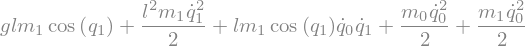

In [8]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [9]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = dynamicsymbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


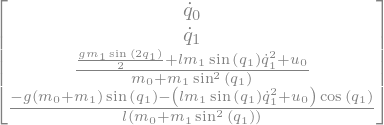

In [10]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

In [11]:
RHS_small.shape

In [12]:
RHS_d = RHS_small.diff(t)
RHS_d = simplify(RHS_d)

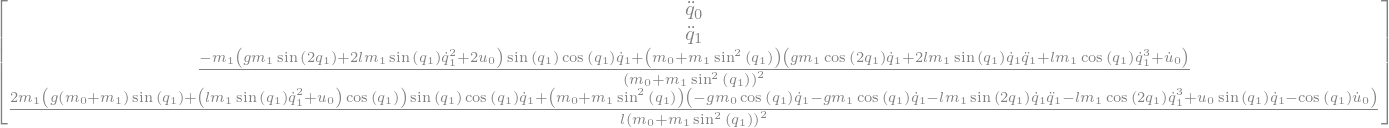

In [13]:
RHS_d

In [14]:
RHS_d_exp = RHS_small.copy()

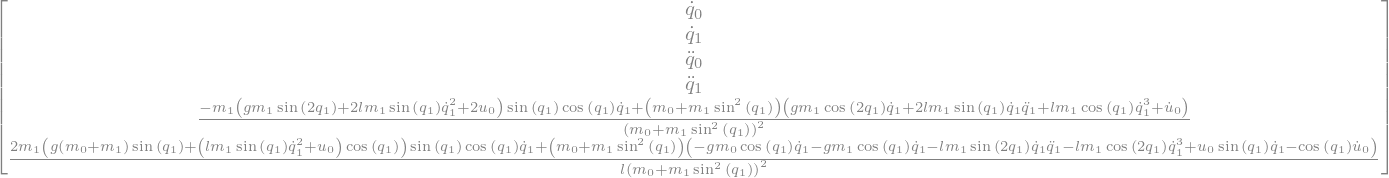

In [15]:
RHS_d_exp = Matrix([RHS_small[i] for i in [0,1]]+[RHS_d[i] for i in range(4)])
RHS_d_exp

In [16]:
q2 = dynamicsymbols('q_2')
q2d = q2.diff()
q2dd = q2d.diff()

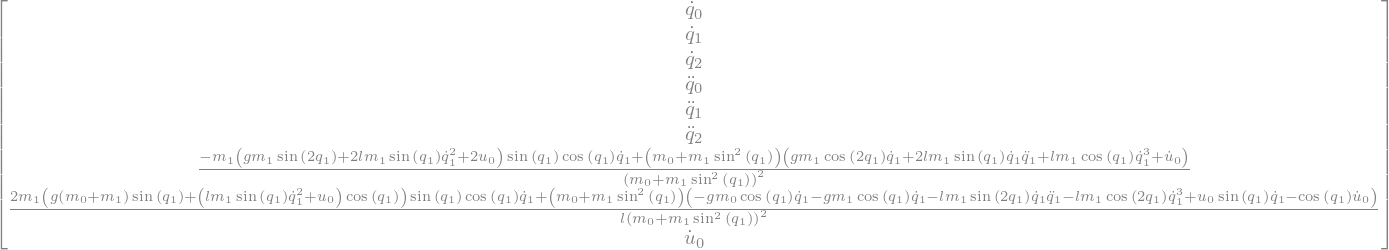

In [17]:
RHS_d_w = RHS_d_exp.row_insert(2, Matrix([q2d]))
RHS_d_w = RHS_d_w.row_insert(5, Matrix([q2dd]))
RHS_d_w = RHS_d_w.row_insert(8, Matrix([u0.diff()]))
RHS_d_w

In [18]:
RHS_d_w.shape

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [19]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [20]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

In [21]:
@lru_cache(maxsize=None)
def casadi_cartpole_prim(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _opti.initial_guess([0,0], [1,np.pi])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [22]:
_res = casadi_cartpole_prim('hs_mod_parab',25, 'lin', solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Explicit Lagranges Method
Generating F function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]

Generating G function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	q: [q_0, q_1]
	v: [v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/I

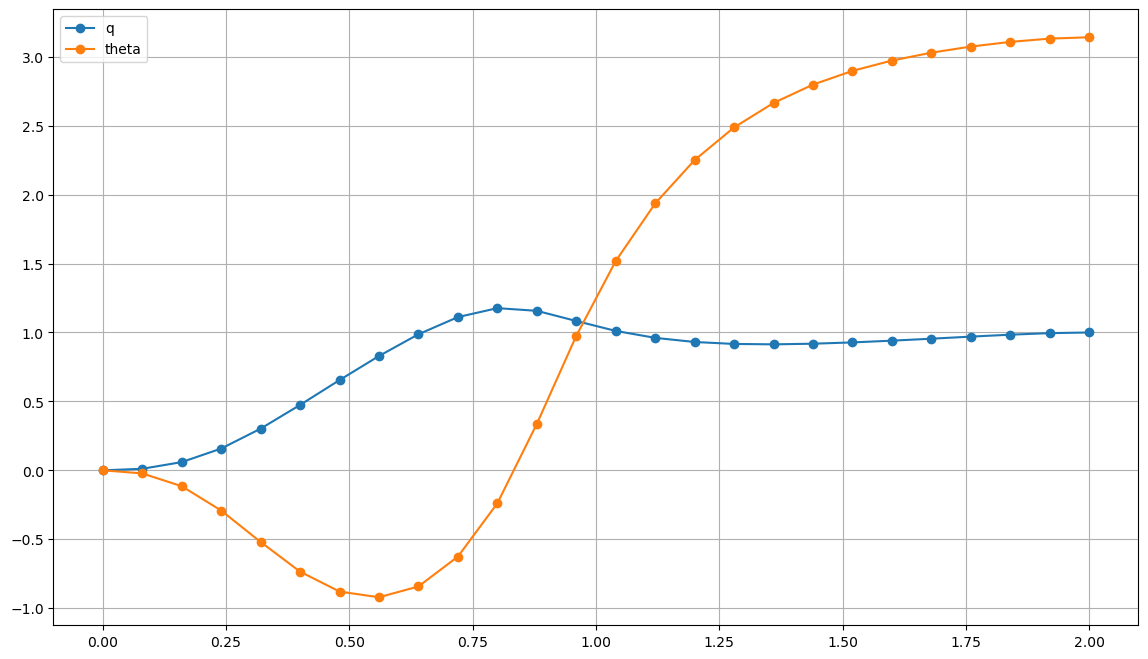

In [23]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', label = labels[ii])
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

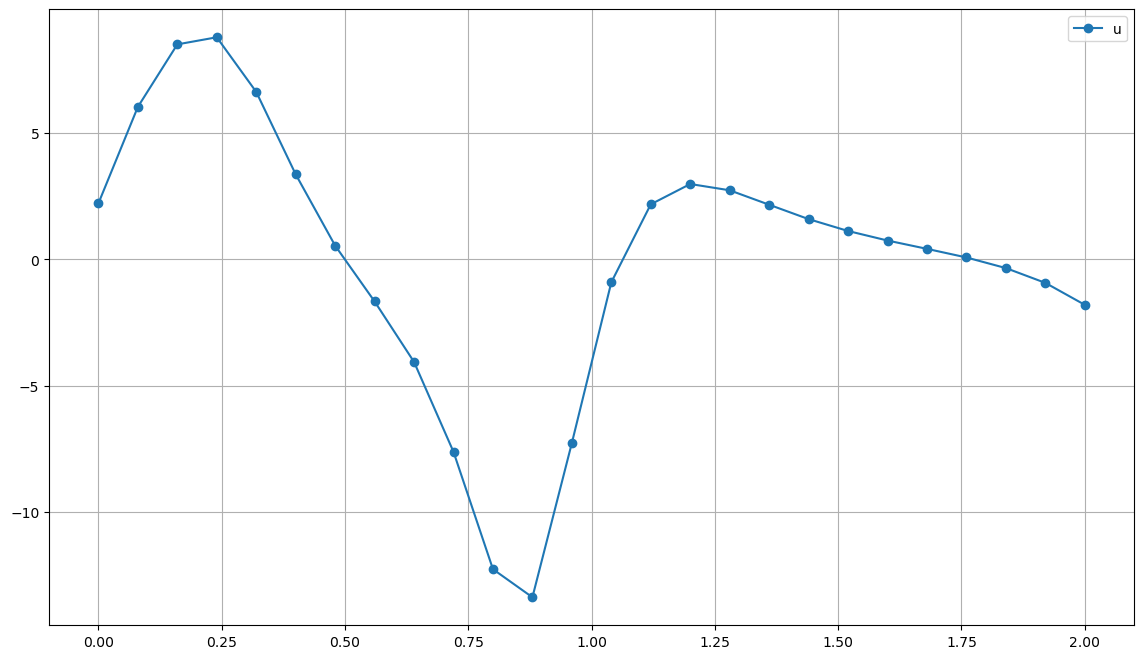

In [24]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:], marker = 'o', label = 'u')
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [25]:
from chords.casadi import implicit_dynamic_x_to_casadi_function

In [26]:
x = dynamicsymbols('x_0:9')

In [27]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [28]:
RHSx=RHS_d_w.subs([
    [u0.diff(), u1],
    [u0, x[8]],
    [q0.diff(t,2), x[6]],
    [q1.diff(t,2), x[7]],
    [q2.diff(t,2), x[8]],
    [q0.diff(t), x[3]],
    [q1.diff(t), x[4]],
    [q2.diff(t), x[5]],
    [q0, x[0]],
    [q1, x[1]],
    [q2, x[2]]
])

RHS_small,RHSx

In [29]:
x_d_mat = Matrix(x_d)

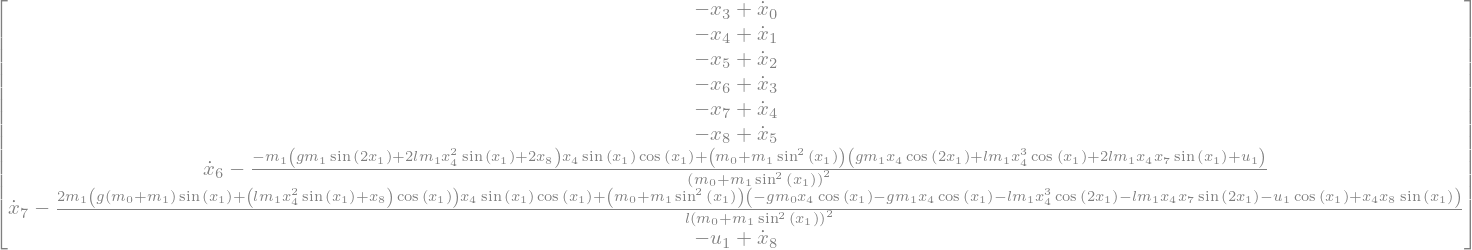

In [30]:
impl_D = x_d_mat-RHSx
impl_D

In [31]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot]
u vars found: [u_1]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
	u: [u_1]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[9],x_dot[9],u,lambdas[0],params[4])->(residue[1x9]) MXFunction)

In [32]:
from chords.piecewise import interpolated_array, interpolated_array_derivative, reduce_F, hs_accel_restr
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy, Sym2Fx
from chords.casadi import rhs_to_casadi_function
import casadi as cas

In [33]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



F_nump_w = RHS2numpy(RHSx, 2)

In [34]:
G_nump = reduce_F(F_nump)

In [35]:
F_nump_w = Sym2Fx(RHSx, x, None, verbose=True)

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_1, x_3, x_4, x_5, x_6, x_7, x_8]
u vars found: [u_1]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	u: [u_1]
	params: [g, l, m_0, m_1]



In [36]:
F_cas = rhs_to_casadi_function(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [37]:
G_cas = reduce_F(F_cas, mode='casadi')

def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[8]
    x = cas.horzcat(q,v)
    f = F_cas(x, u, params)
    g = f[:, 2:]
    opti.subject_to(a == g)

In [38]:
def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[:,8]
    g = G_cas(q, v, u, params)
    opti.subject_to(a == g)

In [39]:
N = 25
scheme = 'hs_parab'

_op = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )


_op.dynamic_setup('f_x_impl', 3, 1, order=3)
_op.opti_setup(N)
_op.initial_guess([0,0,0], [1,np.pi,0])
#_op.sq_cost(_op.opti_arrs['x'][:,8], _op.opti_arrs['x_c'][:,8])
_op.u_sq_cost()
_op.apply_scheme()


opti = _op.opti
X = _op.opti_arrs['x']
U = _op.opti_arrs['u']
X_s = _op.opti_points['x_s']
X_e = _op.opti_points['x_e']

Q_s = X_s[:,:2]
V_s = X_s[:,3:5]
Q_e = X_e[:,:2]
V_e = X_e[:,3:5]
N = _op.N

# Initial and final conditions
opti.subject_to(Q_s.T == [0, 0])
opti.subject_to(Q_e.T == [1, np.pi])
opti.subject_to(V_s.T == [0, 0])
opti.subject_to(V_e.T == [0, 0])
initial_cond_g(_op)

# Appliying restrictions and action boundaries
u_m = 100
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

_op.chrono_solve(solve_repetitions=2,)

_res = _op.results

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     3742
Number of nonzeros in inequality constraint Jacobian.:       26
Number of nonzeros in Lagrangian Hessian.............:      459

Total number of variables............................:      969
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      919
Total number of inequality constraints...............:       26
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       26
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+01 0.00e+00  -1.0 0.00e

print(_res['x'][:, 3:]-_res['x_d'][:, :6])
print(_res['x_c'][:, 3:]-_res['x_d_c'][:, :6])
print(_res['x_d'][:,6:] - _res['jerk'])
print(_res['x_d_c'][:,6:] - _res['jerk_c'])
print(_res['jerk_c'][:,2]-_res['u_c'], _res['jerk'][:,2]-_res['u'])
for ii in range(N):
    print(imp_F_x_cas(_res['x'][ii,:], _res['x_d'][ii,:], _res['u'][ii], [], params))
    print(imp_F_x_cas(_res['x_c'][ii,:], _res['x_d_c'][ii,:], _res['u_c'][ii], [], params))

dt = (_res['t'][-1]-_res['t'][0])/N
for ii in range(N):
    print(hs_accel_restr(
    _res['x'][ii,:],
    _res['x'][ii+1,:],
    _res['jerk'][ii],
    _res['jerk'][ii+1,:],
    dt,
    _res['jerk_c'][ii]
))

for ii in range(N):
    print(G_nump(_res['q'][ii,:2], _res['v'][ii,:2], _res['a'][ii,2], params)-_res['a'][ii,:2])

In [40]:
plot_n = 1000
t_interp = np.linspace(0, 2, plot_n)
marker_size = 5
dt = (_res['t'][-1]-_res['t'][0])/N

if 'parab' in scheme:
    u_scheme = 'parab'
    sch_param = {
        'u_c':_res['u_c'],
        "x_dot_c":_res['x_d_c'],
        "order":3}
elif 'hs' in scheme:
    u_scheme = 'lin'
    sch_param = {"order":3,
        "x_dot_c":_res['x_d_c'],}
else: 
    u_scheme = 'lin'
    sch_param = {"order":3,}
x_interp, u_interp = interpolated_array(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    u_scheme=u_scheme,
    scheme_params=sch_param,
)
x_d_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=1,
    scheme_params=sch_param,)

q_dd_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=3,
    scheme_params=sch_param,)[:, :3]

q_interp =x_interp[:, :3]
v_interp =x_interp[:, 3:6]
a_interp =x_interp[:, 6:]
q_d_interp = x_d_interp[:, :3]
j_interp =x_d_interp[:, 6:]

Text(0.5, 1.0, 'q and theta ')

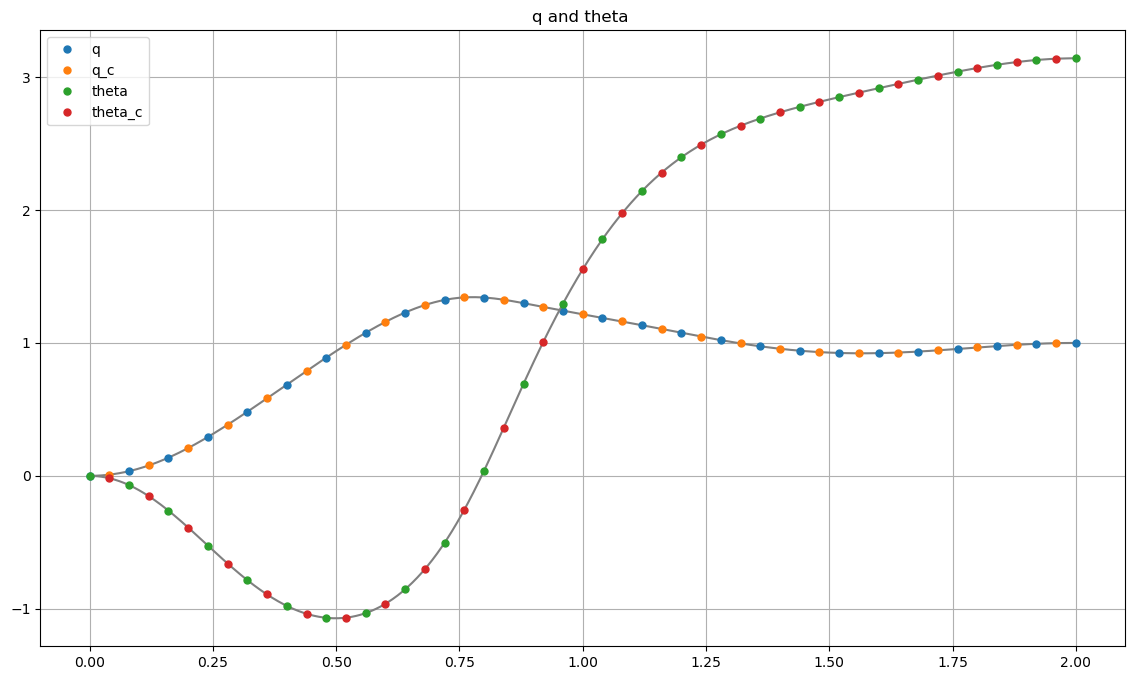

In [41]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(t_interp, q_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

Text(0.5, 1.0, 'q and theta velocities in X')

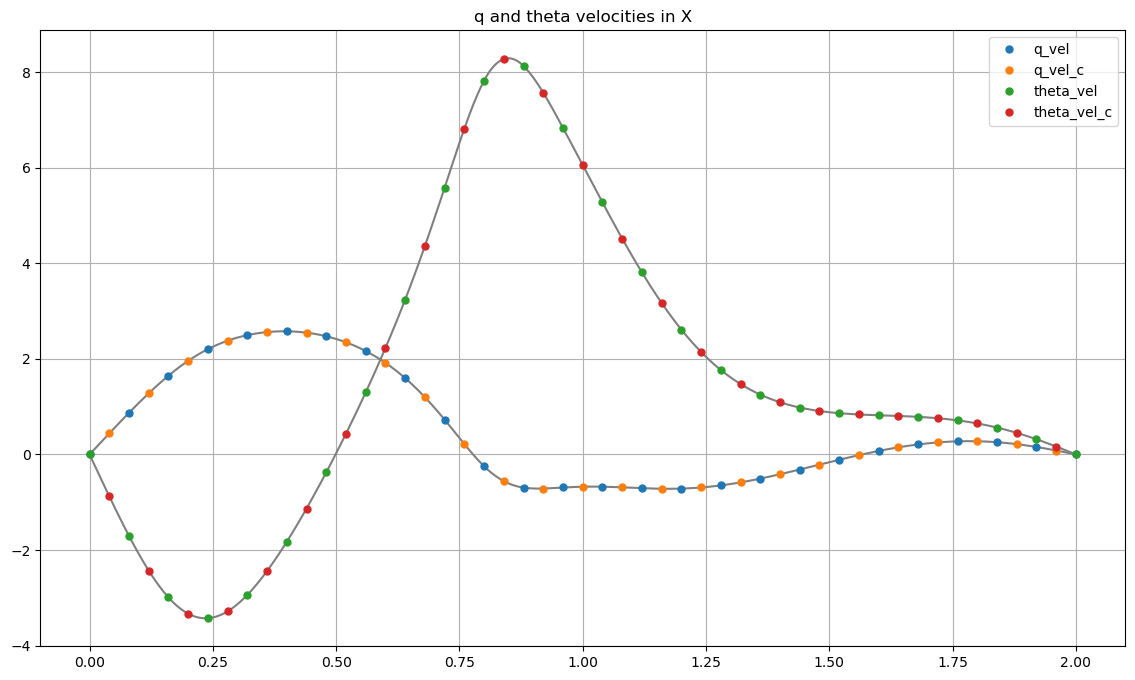

In [42]:
plt.figure(figsize=[14,8])
labels= ['q_vel', 'theta_vel']
for ii in range(2):
    plt.plot(t_interp, v_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['v'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['v_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta velocities in X')

Text(0.5, 1.0, 'q and theta accelerations in X')

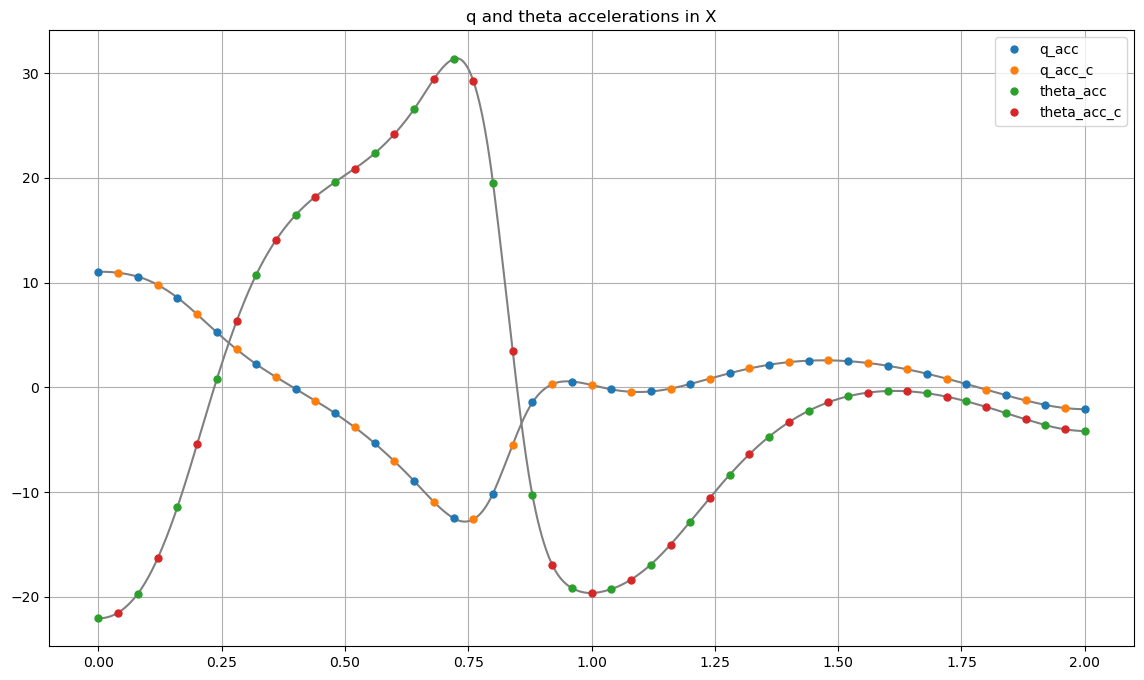

In [43]:
plt.figure(figsize=[14,8])
labels= ['q_acc', 'theta_acc']
for ii in range(2):
    plt.plot(t_interp, a_interp[:,ii], c = 'grey')    
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['a_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta accelerations in X')

Text(0.5, 1.0, 'q and theta Jerk in $ \\dot{X} $')

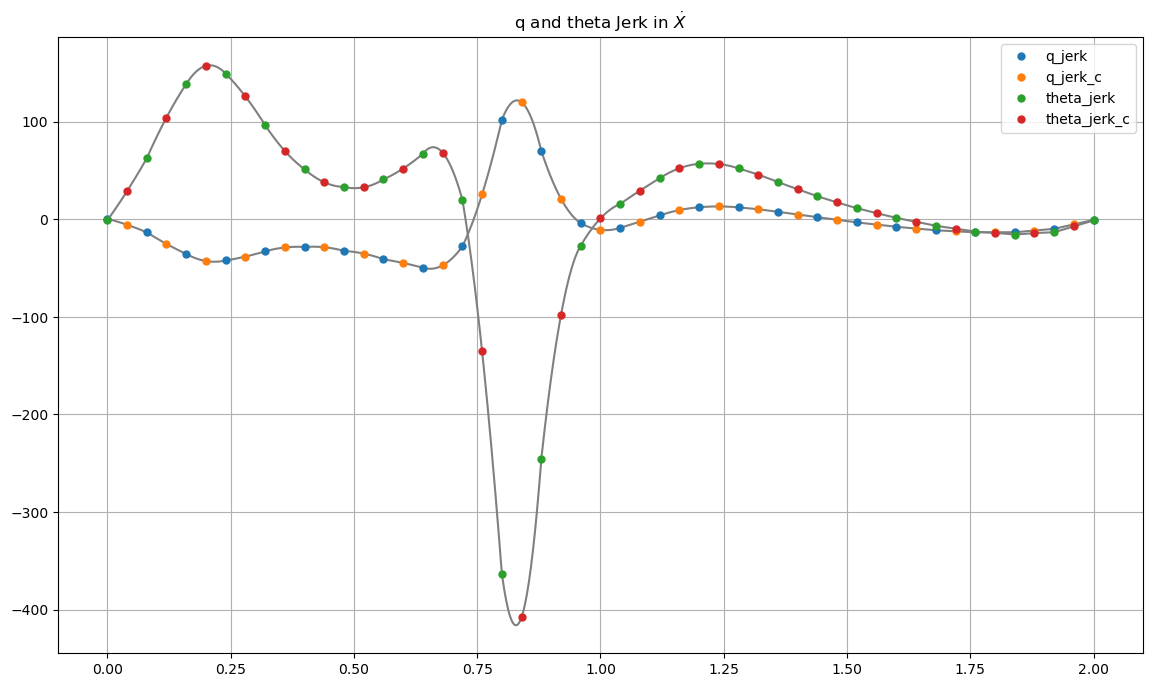

In [44]:
plt.figure(figsize=[14,8])
labels= ['q_jerk', 'theta_jerk']
for ii in range(2):
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii],  'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta Jerk in $ \dot{X} $')

Text(0.5, 1.0, 'q and theta interpolation first derivatives')

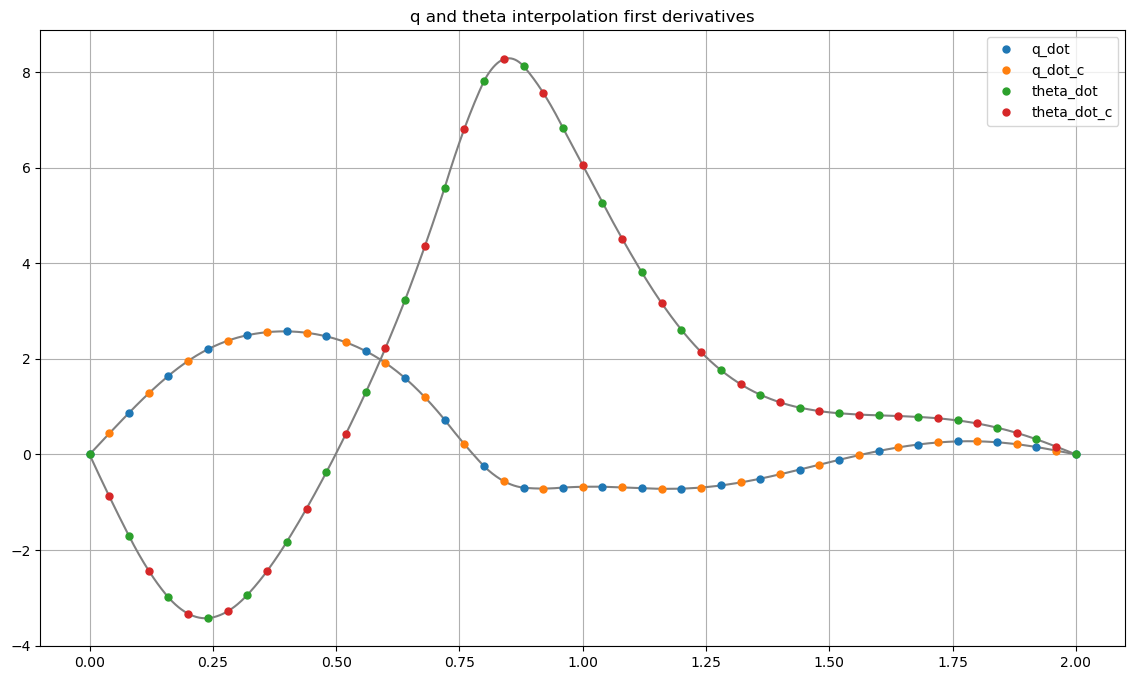

In [45]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(t_interp, q_d_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['v'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation first derivatives')

Text(0.5, 1.0, 'q and theta interpolation second derivatives')

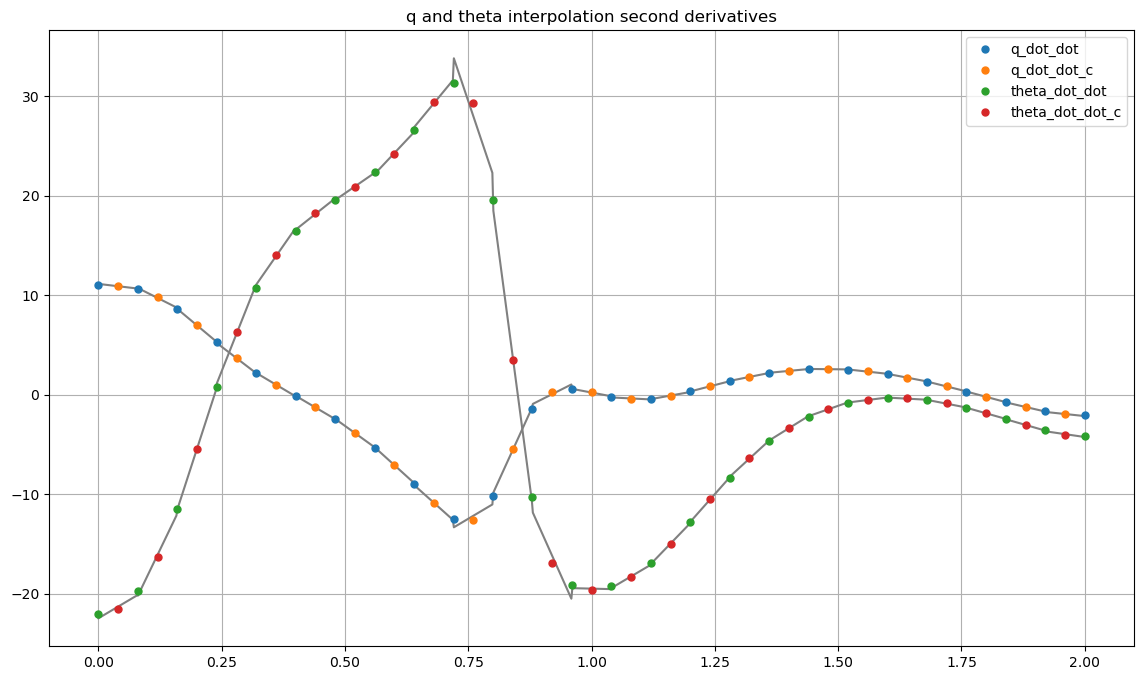

In [46]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(t_interp, q_dd_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['a_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation second derivatives')

Text(0.5, 1.0, 'q and theta interpolation third derivatives')

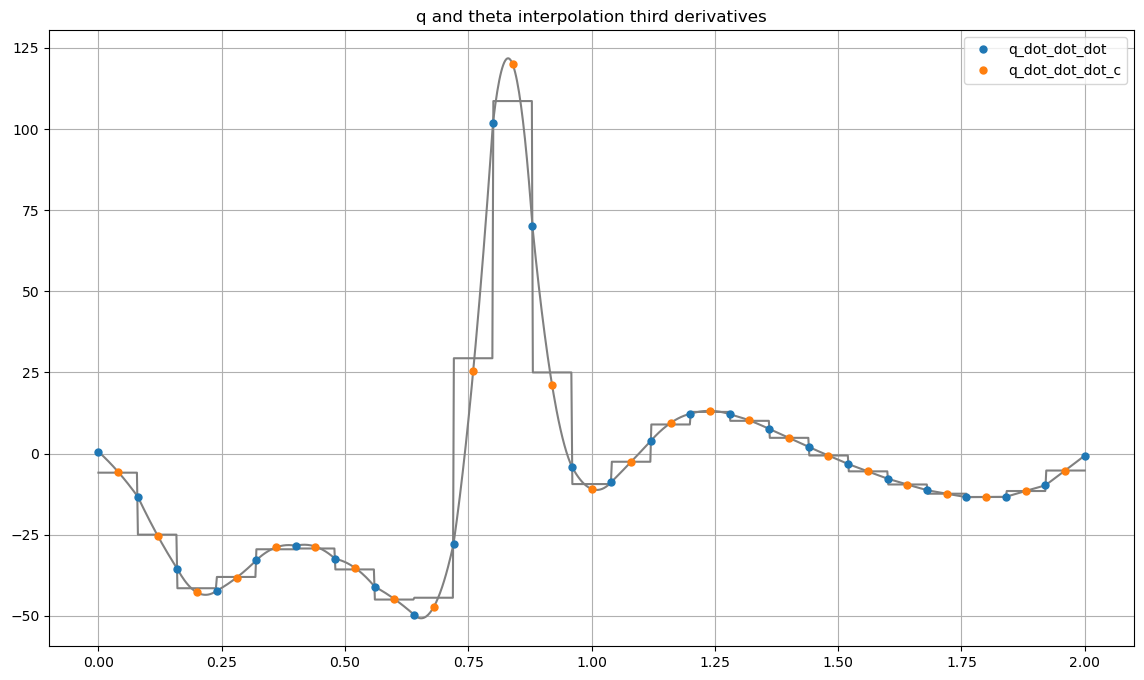

In [47]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot_dot', 'theta_dot_dot_dot']
for ii in range(1):
    plt.plot(t_interp, q_ddd_interp[:,ii], c = 'grey')
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation third derivatives')

Text(0.5, 1.0, 'u as component of X')

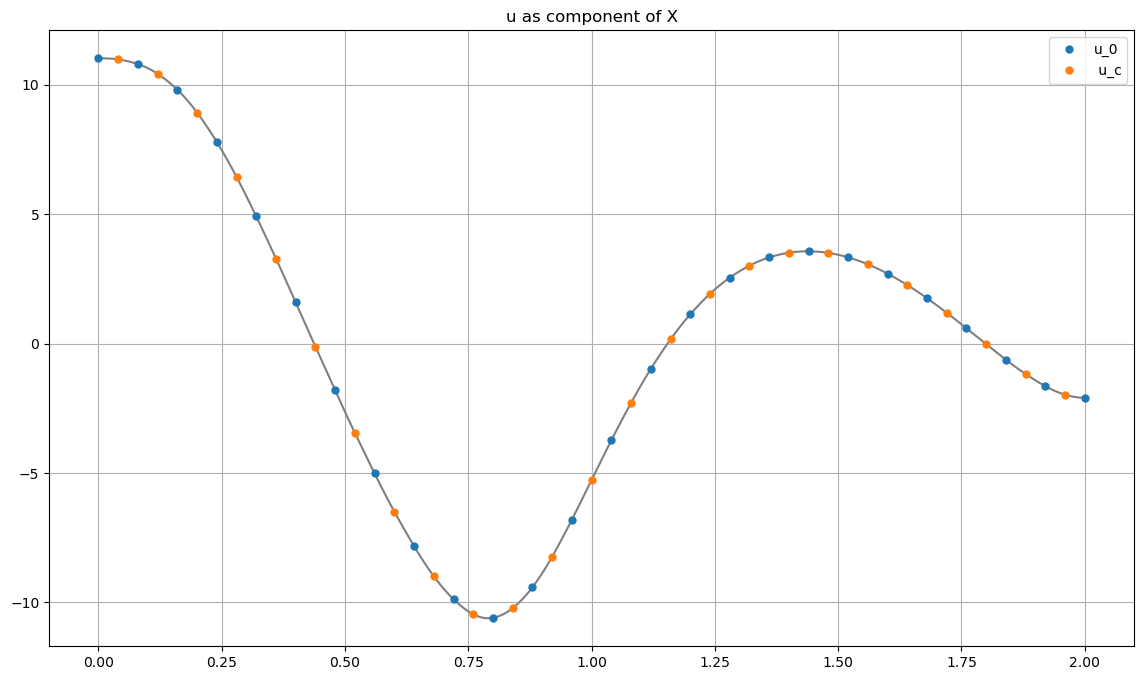

In [48]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(t_interp, a_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = 'u_0')
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['a_c'][:,ii],  'o', ms =marker_size, label = ' u_c')
plt.grid()
plt.legend()
plt.title('u as component of X')

Text(0.5, 1.0, 'u_dot as component of $\\dot{X}$')

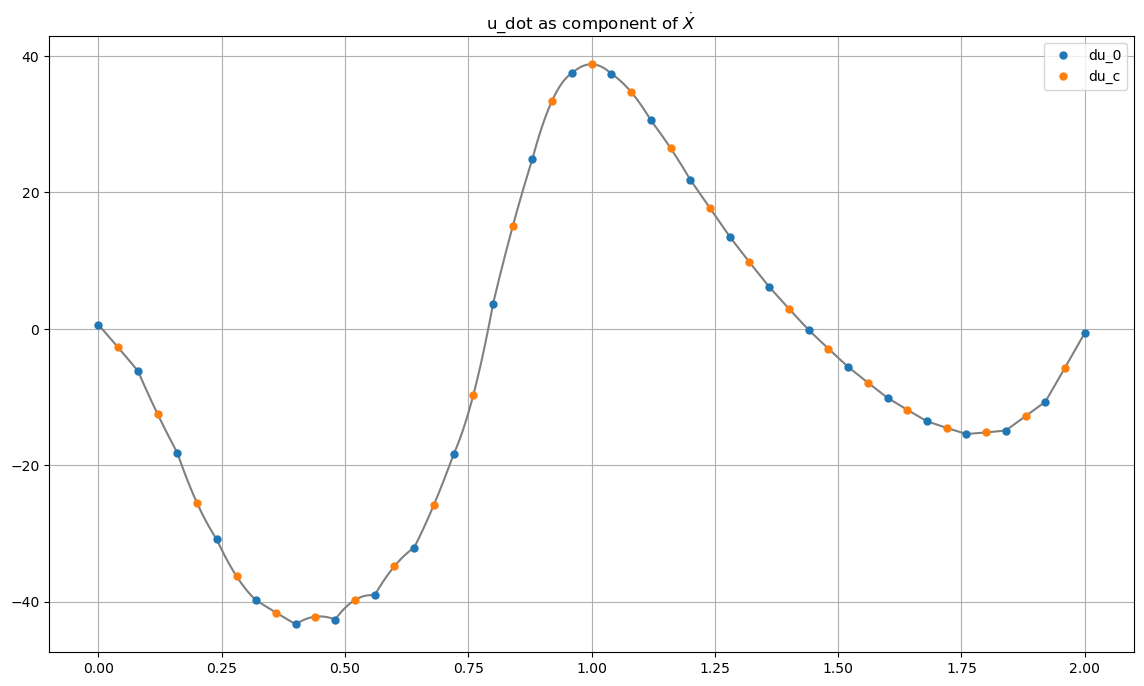

In [49]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii],  'o', ms =marker_size, label = 'du_0')
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii],  'o', ms =marker_size, label = 'du_c')
plt.grid()
plt.legend()
plt.title('u_dot as component of $\dot{X}$')

Text(0.5, 1.0, 'u_dot as w in control')

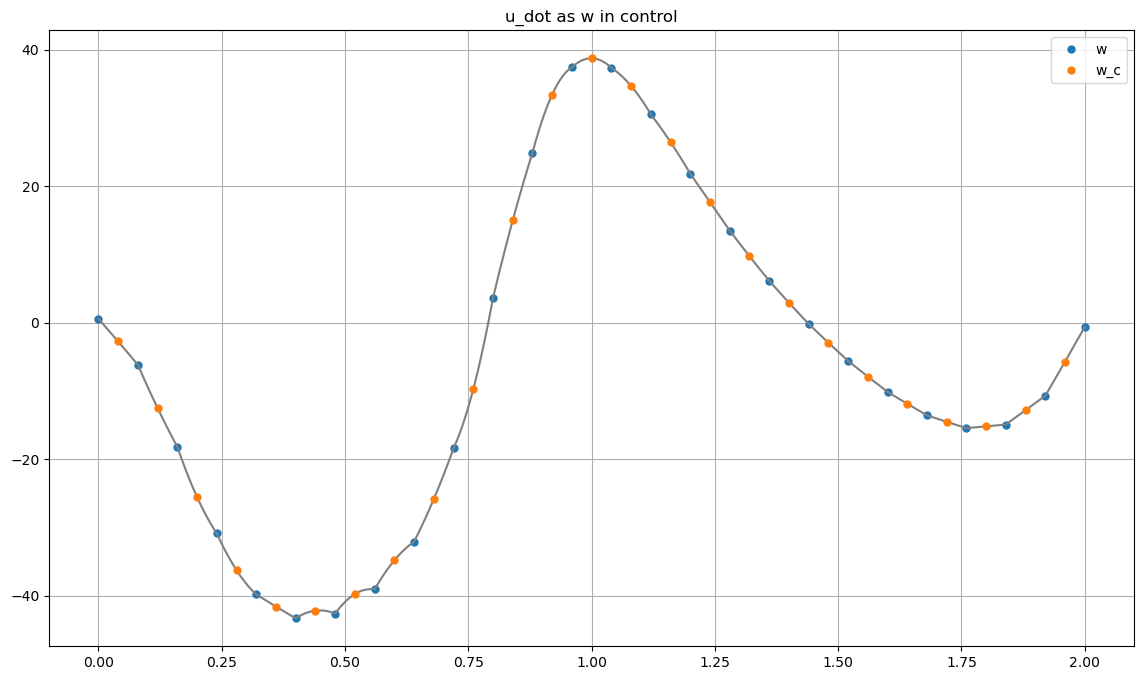

In [50]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:],  'o', ms =marker_size, label = 'w')
plt.plot(t_interp, u_interp[:], c = 'grey')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['u_c'][:],  'o', ms =marker_size, label = 'w_c')
plt.grid()
plt.legend()

plt.title('u_dot as w in control')

In [51]:
_res['x'][0]

array([  0.        ,   0.        , -34.94417171,   0.        ,
         0.        ,  -8.65640238,  11.02787705, -22.0557541 ,
        11.02787705])

In [52]:
F_nump_w(_res['x'][0], _res['u'][0], params)

array([  0.        ,   0.        ,  -8.65640238,  11.02787705,
       -22.0557541 ,  11.02787705,   0.59513462,  -1.19026924,
         0.59513462])

In [53]:
_res['x_d'][0]

array([  0.        ,   0.        ,  -8.65640238,  11.02787705,
       -22.0557541 ,  11.02787705,   0.59513462,  -1.19026924,
         0.59513462])

In [54]:
_res['cost']

In [55]:
N = 25
scheme = 'hs_parab'

_opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )


_opti.dynamic_setup('f_x_impl', 3, 1, order=3)
_opti.opti_setup(N)
_opti.initial_guess([0,0,0], [1,np.pi,0])
#_opti.sq_cost(_opti.opti_arrs['x'][:,8], _opti.opti_arrs['x_c'][:,8])
_opti.u_sq_cost()
_opti.apply_scheme()


opti = _opti.opti
X = _opti.opti_arrs['x']
U = _opti.opti_arrs['u']
X_s = _opti.opti_points['x_s']
X_e = _opti.opti_points['x_e']

Q_s = X_s[:,:2]
V_s = X_s[:,3:5]
Q_e = X_e[:,:2]
V_e = X_e[:,3:5]
N = _opti.N

# Initial and final conditions
opti.subject_to(Q_s.T == [0, 0])
opti.subject_to(Q_e.T == [1, np.pi])
opti.subject_to(V_s.T == [0, 0])
opti.subject_to(V_e.T == [0, 0])
initial_cond_g(_opti)

# Appliying restrictions and action boundaries
u_m = 100
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

_opti.chrono_solve(solve_repetitions=2,)

_res = _opti.results

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     3742
Number of nonzeros in inequality constraint Jacobian.:       26
Number of nonzeros in Lagrangian Hessian.............:      459

Total number of variables............................:      969
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      919
Total number of inequality constraints...............:       26
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       26
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+01 0.00e+00  -1.0 0.00e

In [56]:
@lru_cache(maxsize=None)
def casadi_cartpole_w(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )


    _opti.dynamic_setup('f_x_impl', 3, 1, order=3)
    _opti.opti_setup(N)
    _opti.initial_guess([0,0,0], [1,np.pi,0])
    #_opti.sq_cost(_opti.opti_arrs['x'][:,8], _opti.opti_arrs['x_c'][:,8])
    _opti.u_sq_cost()
    _opti.apply_scheme()


    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']

    Q_s = X_s[:,:2]
    V_s = X_s[:,3:5]
    Q_e = X_e[:,:2]
    V_e = X_e[:,3:5]

    # Initial and final conditions
    opti.subject_to(Q_s.T == [0, 0])
    opti.subject_to(Q_e.T == [1, np.pi])
    opti.subject_to(V_s.T == [0, 0])
    opti.subject_to(V_e.T == [0, 0])
    initial_cond_g(_opti)

    # Appliying restrictions and action boundaries
    u_m = 100
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

    _opti.chrono_solve(solve_repetitions=solve_repetitions,)

    return _opti.results

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [57]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [58]:
schemes = ['hs_parab', 'hsn_parab', 'trapz', 'trapz_n'] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 10 #Increase this number to get more reliable values of execution times
#N_arr = [20, 25, 50]
N_arr = [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]# You can increase the numbers here, but it will take more time
results = {}

for scheme in schemes:
    key = scheme
    print('Problem:', key)
    results[key] = {'N_arr':N_arr}
    for N in N_arr:
        print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        results[key][N] = casadi_cartpole_w(
            scheme,
            N, 
            'lin',
            solve_repetitions=solve_repetitions,
            silent=True, 
            verbose=False)


Problem: hs_parab
	N = 20 ,  11:29:44 
	N = 25 ,  11:29:44 
	N = 30 ,  11:29:45 
	N = 40 ,  11:29:46 
	N = 50 ,  11:29:47 
	N = 60 ,  11:29:48 
	N = 80 ,  11:29:50 
	N = 100 ,  11:29:53 
	N = 120 ,  11:29:57 
	N = 160 ,  11:30:00 
	N = 200 ,  11:30:08 
Problem: hsn_parab
	N = 20 ,  11:30:18 
	N = 25 ,  11:30:19 
	N = 30 ,  11:30:19 
	N = 40 ,  11:30:20 
	N = 50 ,  11:30:21 
	N = 60 ,  11:30:23 
	N = 80 ,  11:30:24 
	N = 100 ,  11:30:26 
	N = 120 ,  11:30:29 
	N = 160 ,  11:30:33 
	N = 200 ,  11:30:38 
Problem: trapz
	N = 20 ,  11:30:44 
	N = 25 ,  11:30:44 
	N = 30 ,  11:30:45 
	N = 40 ,  11:30:45 
	N = 50 ,  11:30:45 
	N = 60 ,  11:30:46 
	N = 80 ,  11:30:47 
	N = 100 ,  11:30:48 
	N = 120 ,  11:30:49 
	N = 160 ,  11:30:51 
	N = 200 ,  11:30:53 
Problem: trapz_n
	N = 20 ,  11:30:55 
	N = 25 ,  11:30:56 
	N = 30 ,  11:30:56 
	N = 40 ,  11:30:57 
	N = 50 ,  11:30:57 
	N = 60 ,  11:30:58 
	N = 80 ,  11:30:59 
	N = 100 ,  11:31:00 
	N = 120 ,  11:31:01 
	N = 160 ,  11:31:02 
	N = 200 ,  1

plt.figure(figsize=[14,8])
scheme = 'hs_parab'
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],results['hs_parab'][25]['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],results['hs_parab'][25]['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


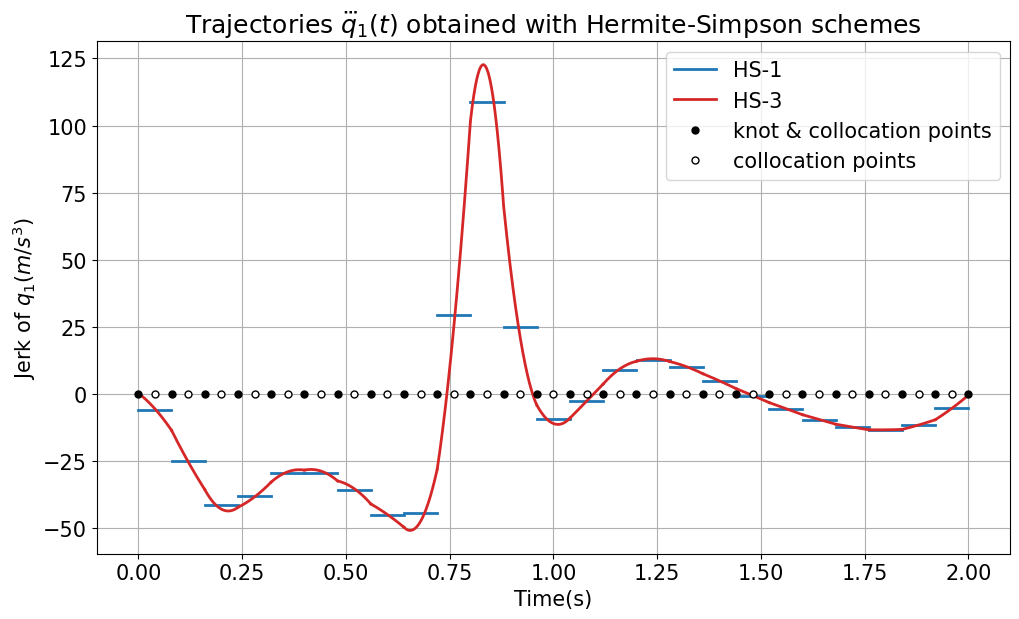

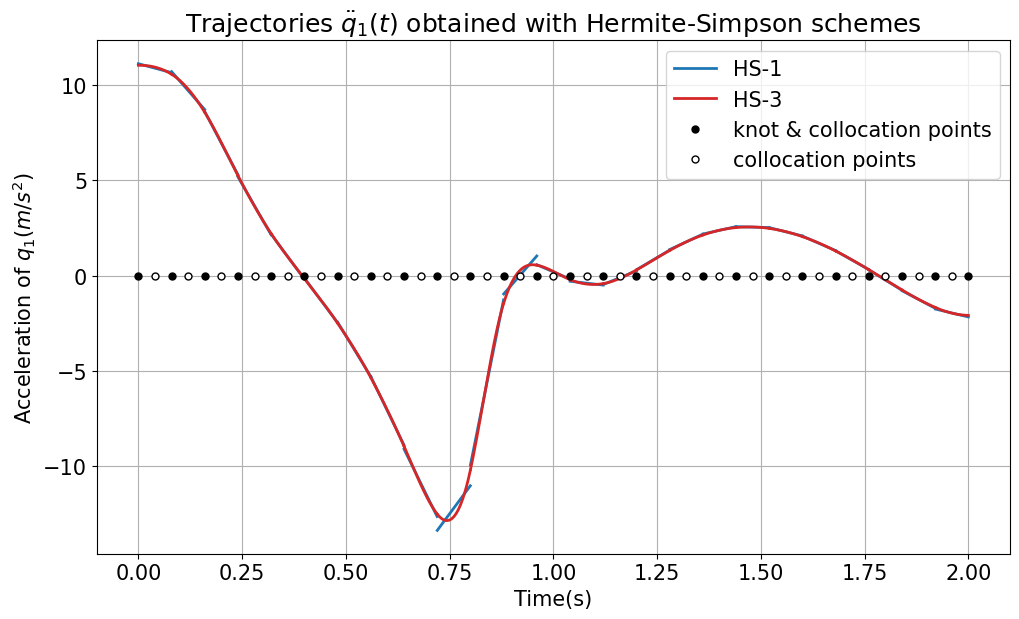

In [96]:
plot_n = 5000
t_interp = np.linspace(0, 2, plot_n)
marker_size = 5
N = 25
dt = (_res['t'][-1]-_res['t'][0])/N

#HS1

_res = results['hs_parab'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]

#HS3

_res = results['hsn_parab'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]


schemes_label = ['HS-1', 'HS-3']
schemes_plot = ['hs', 'hsn']
y_plot_list = [q_ddd_interp_hs1[:,0], q_ddd_interp_hs3[:,0]]
y_plot_list_2 = [q_dd_interp_hs1[:,0], q_dd_interp_hs3[:,0]]
plots = [y_plot_list, y_plot_list_2]
y_labels = ["Jerk of $q_1 (m/s^3)$","Acceleration of $q_1 (m/s^2)$"]
_dd = ["ddd", "dd"]

for kk in range(2):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for ii in range(2):

        t_arr = t_interp
        interv_n = (N * t_arr) / _res["t"][-1]
        cut_p = 0
        y_plot = plots[kk][ii]
        scheme = schemes_plot[ii]
        label = schemes_label[ii]
        name = label.replace('HS', 'Hermite-Simpson')
        for ll in range(1, N + 1):
            jj = np.searchsorted(interv_n, ll)
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                "-",
                lw=2,
                c=sch_to_color(scheme),
                label=label if cut_p == 0 else None,
            )
            cut_p = jj
    if "hs" in scheme:
        plot_coll_p = True
    plt.plot(
        _res["t"],
        np.zeros(N + 1),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    if plot_coll_p:
        plt.plot(
            _res["t_c"],
            np.zeros(N),
            "ow",
            ms=5,
            markeredgecolor="k",
            label="collocation points",
        )
    plt.legend()
    plt.grid()
    # plt.ylim([-0.01,y_max_list[ii]])
    plt.title(f"Trajectories $\{_dd[kk]}"+"ot{q}_1(t)$ obtained with Hermite-Simpson schemes")
    plt.xlabel("Time(s)")
    plt.ylabel(y_labels[kk])
    plt.tight_layout(pad=0.0)
    plt.savefig(f'2d_order/Cartpole_deriv_q{_dd[kk]}_HS_schemes_N_{N}.eps', format='eps')

In [60]:
#Calculating the number of collocation points
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']

In [61]:
for scheme in schemes:
    key = scheme
    _c = []
    _cpudt = []
    _iters = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
        _iters.append(results[key][N]['iter_count'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)
    results[key]['iter_count'] = np.array(_iters)

Text(0.5, 1.0, 'Final traj cost')

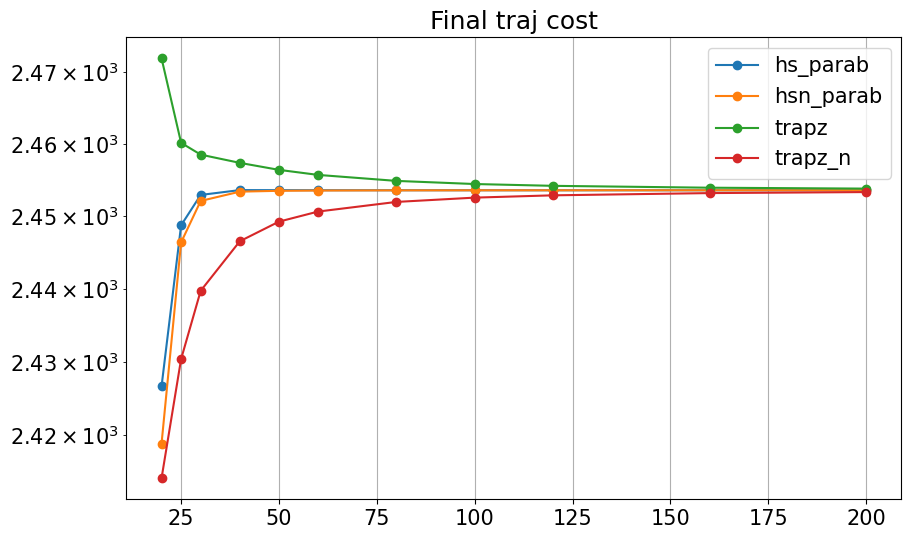

In [62]:
plt.figure(figsize=oct_fig_size)
for scheme in schemes:
    key = scheme
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], marker = 'o', label = scheme)
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [63]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [64]:
#schemes = ['hs_parab', 'hsn_parab', 'trapz', 'trapz_n']
n_interp = 2000
for scheme in schemes:
    key = scheme 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        if 'parab' in scheme:
            u_scheme = 'parab'
            sch_param = {'u_c':results[key][N]['u_c']}
        else:
            u_scheme = 'lin'
            sch_param = {}
        dynamic_errors = dynamic_error(
            results[key][N]['x'],
            results[key][N]['u'],
            2,
            params,
            F_nump_w,
            scheme = scheme,
            u_scheme= u_scheme,
            scheme_params= sch_param,
            n_interp = n_interp,
            order=3,
            mode='q')
        dyn_err_q = dynamic_errors[0][0]
        dyn_err_v = dynamic_errors[0][1]
        dyn_err_2 = dynamic_errors[1][0]
        dyn_err_3 = dynamic_errors[2][0]
        results[key][N]['dyn_err_q'] = dyn_err_q
        results[key][N]['dyn_err_v'] = dyn_err_v
        results[key][N]['dyn_err_2'] = dyn_err_2
        results[key][N]['dyn_err_3'] = dyn_err_3
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        tot_dyn_err_3 = total_state_error(t_arr, dyn_err_3)
        results[key][N]['err_q_int'] = dyn_err_q
        results[key][N]['err_v_int'] = dyn_err_v
        results[key][N]['err_2_int'] = dyn_err_2
        results[key][N]['err_3_int'] = dyn_err_3
        results[key][N]['err_q'] = tot_dyn_err_q
        results[key][N]['err_v'] = tot_dyn_err_v
        results[key][N]['err_2'] = tot_dyn_err_2
        results[key][N]['err_3'] = tot_dyn_err_3
            

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hsn_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_n
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


In [65]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [66]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_v_acum = []
    err_3_acum = []
    cpudt = []
    for N in N_arr:
        err_q_acum.append(results[key][N]['err_q'])
        err_v_acum.append(results[key][N]['err_v'])
        err_3_acum.append(results[key][N]['err_3'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
    results[key]['err_3_acum'] = np.array(err_3_acum, dtype = float)
    

Problem: hs_parab
Problem: hsn_parab
Problem: trapz
Problem: trapz_n


In [67]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_3'].shape[0])
        
        if 'hs' in key:
            scheme_params={'u_c':_case['u_c'],
                          'x_dot_c': _case['x_d_c'],
                          'x_c': _case['x_c'],
                          'order': 3}
        else:
            scheme_params={'order': 3}
            
        _derivs = interpolated_array_derivative(
            _case['x'],
            _case['u'],
            _case['t'][-1]/(_case['t'].shape[0]-1),
            t_array = t_arr,
            params=params,
            F=None,
            X_dot=_case['x_d'],
            scheme=key,
            order=1,
            scheme_params=scheme_params,)
        _accels = _derivs[:, 6:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_3_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_3_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_3']/_case['a_arr'])
        _case['rel_dyn_err_3_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_3_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_3']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_3_arr_by_a_sum_arr_sum'] = None

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hsn_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_n
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [68]:
from chords.util import plot_by_segments

In [69]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'x', 'x_d', 'u', 't', 'lam', 'q', 'v', 'a', 'jerk', 'dyn_err_q', 'dyn_err_v', 'dyn_err_2', 'dyn_err_3', 'err_q_int', 'err_v_int', 'err_2_int', 'err_3_int', 'err_q', 'err_v', 'err_2', 'err_3', 'sum_dyn_err_3_arr', 'a_arr', 'a_abs_mean_by_component', 'a_abs_mean', 'a_abs_sum_arr', 'rel_dyn_err_3_arr_by_instant_a_sum', 'rel_dyn_err_3_arr_by_total_mean_sum', 'rel_dyn_err_3_arr_by_mean_by_component_sum', 'rel_dyn_err_3_arr_by_a_sum_arr_sum'])

In [70]:
results['trapz'][50]['t'].shape

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


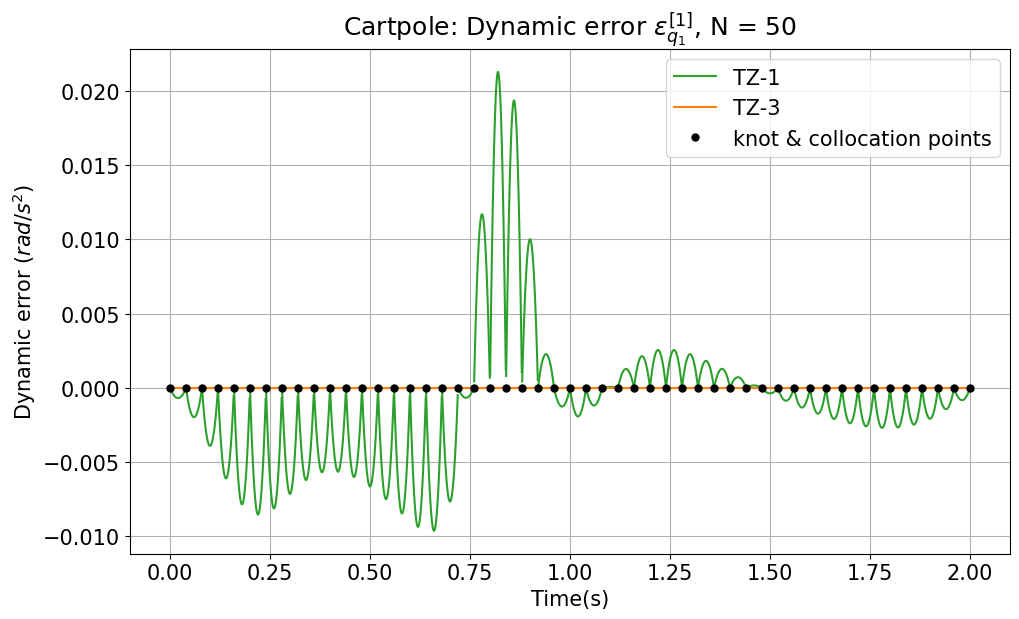

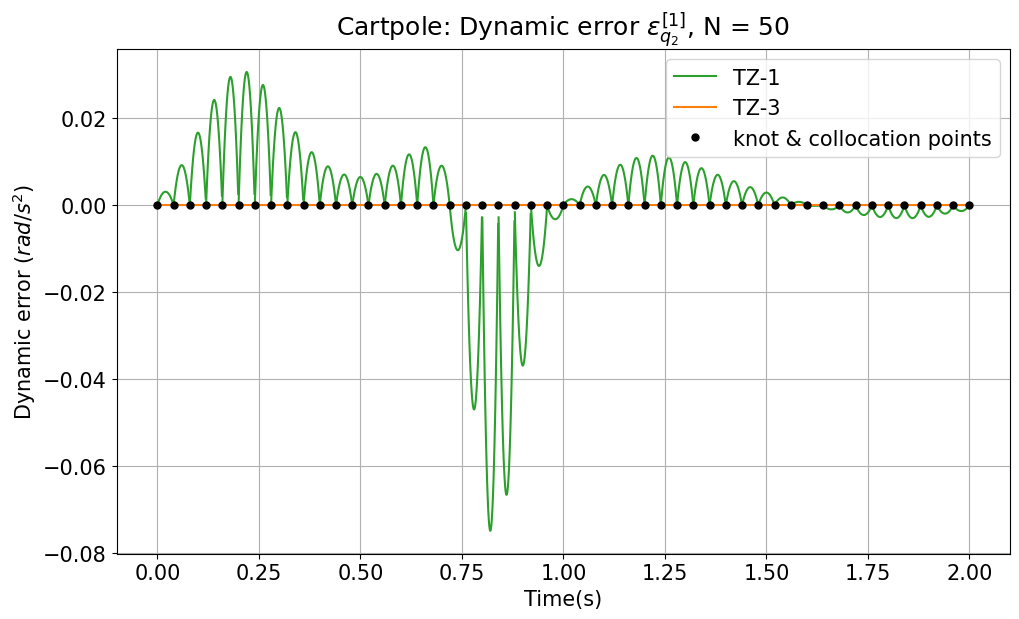

In [71]:
schemes = ['trapz', 'trapz_n']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_First_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


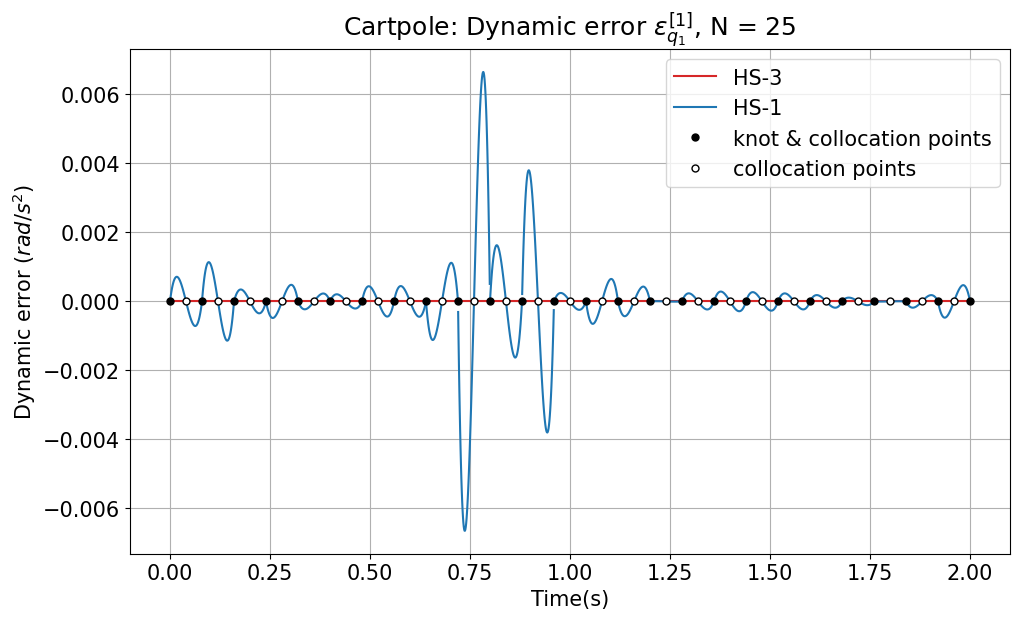

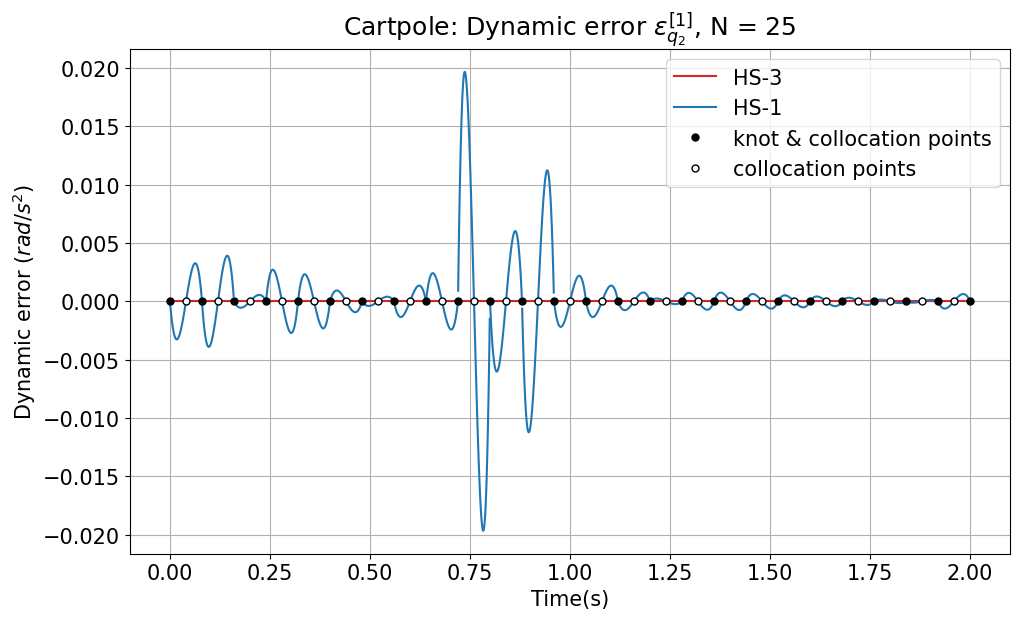

In [72]:
schemes = ['hsn_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_First_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


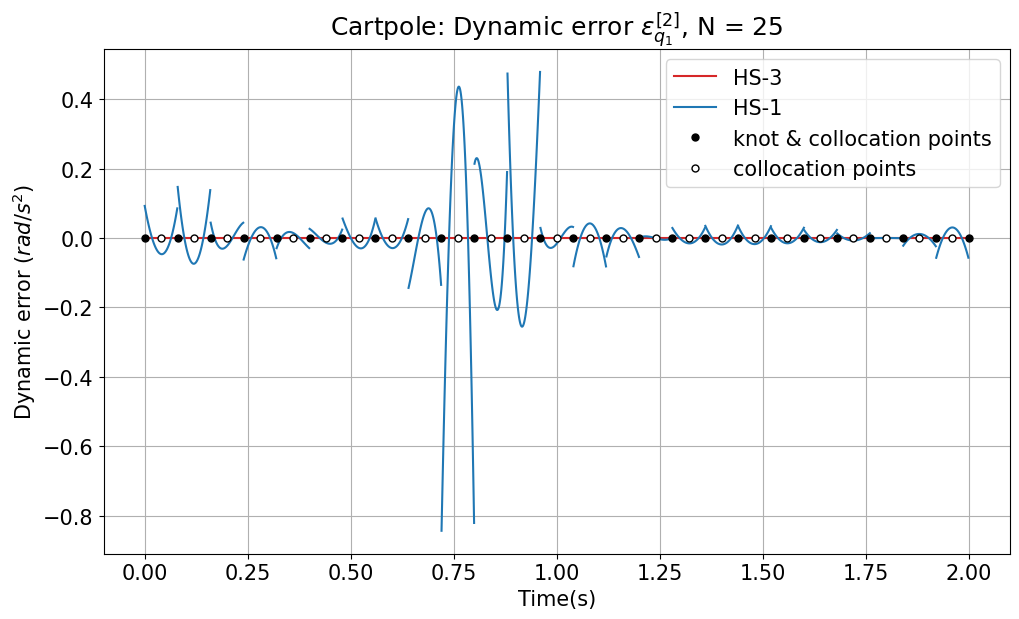

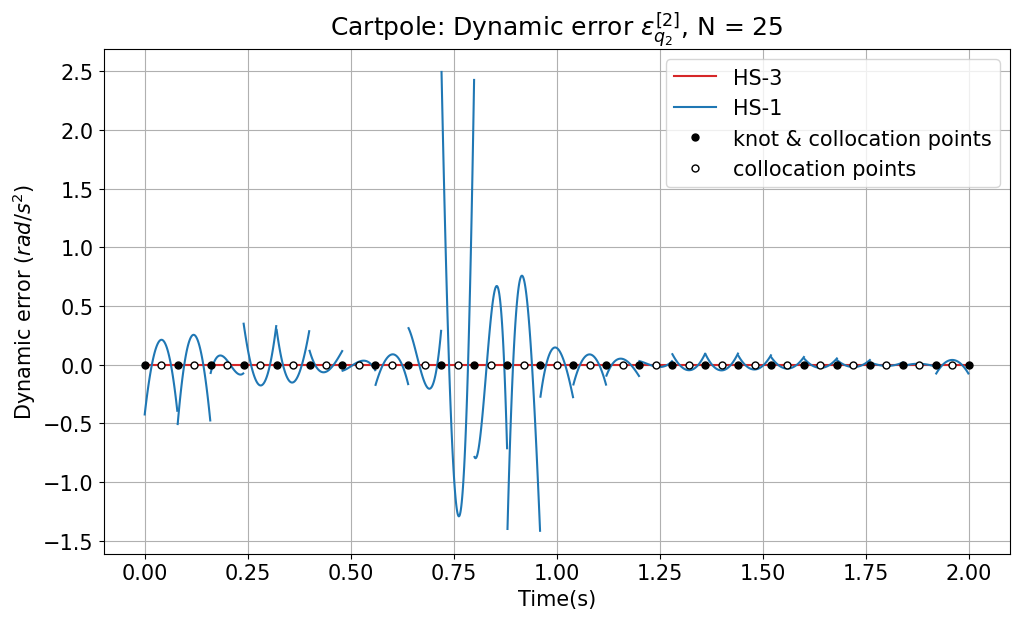

In [73]:
schemes = ['hsn_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_Second_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


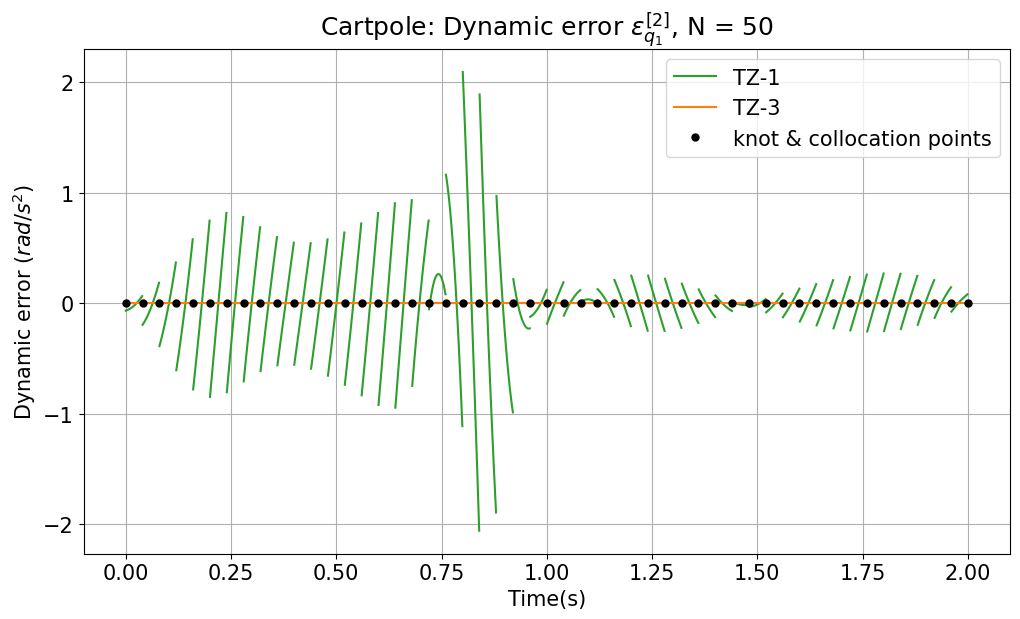

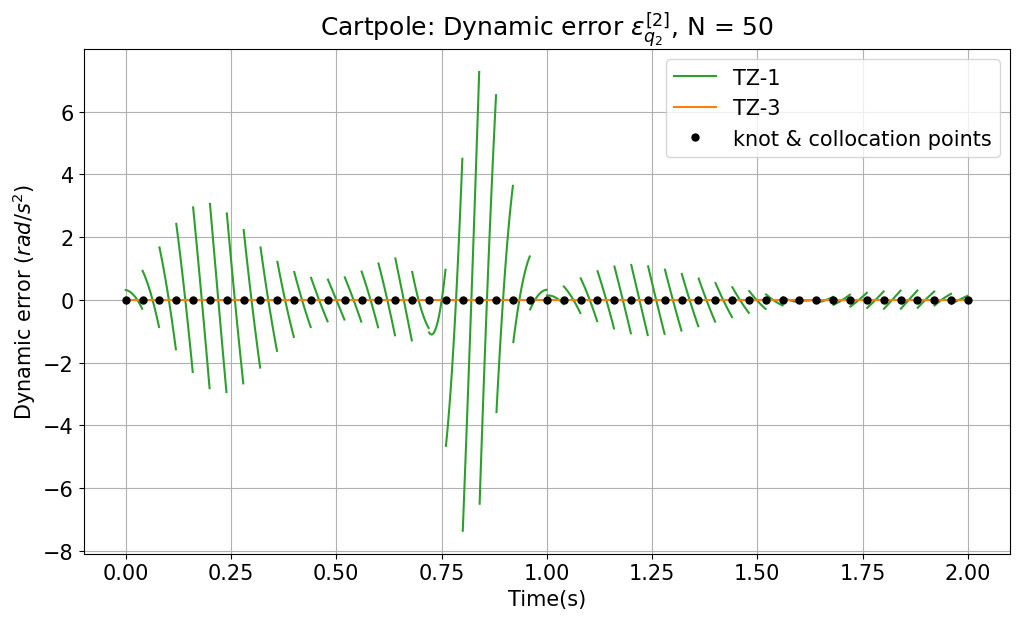

In [74]:
schemes = ['trapz', 'trapz_n']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_Second_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

#### Relative Errors

In [75]:
error_types = ['rel_dyn_err_3_arr_by_instant_a_sum',
 'rel_dyn_err_3_arr_by_mean_by_component_sum',]
error_titles = [error.replace('rel_dyn_err_3_arr_', '').replace('_', ' ')[:-4] for error in error_types]

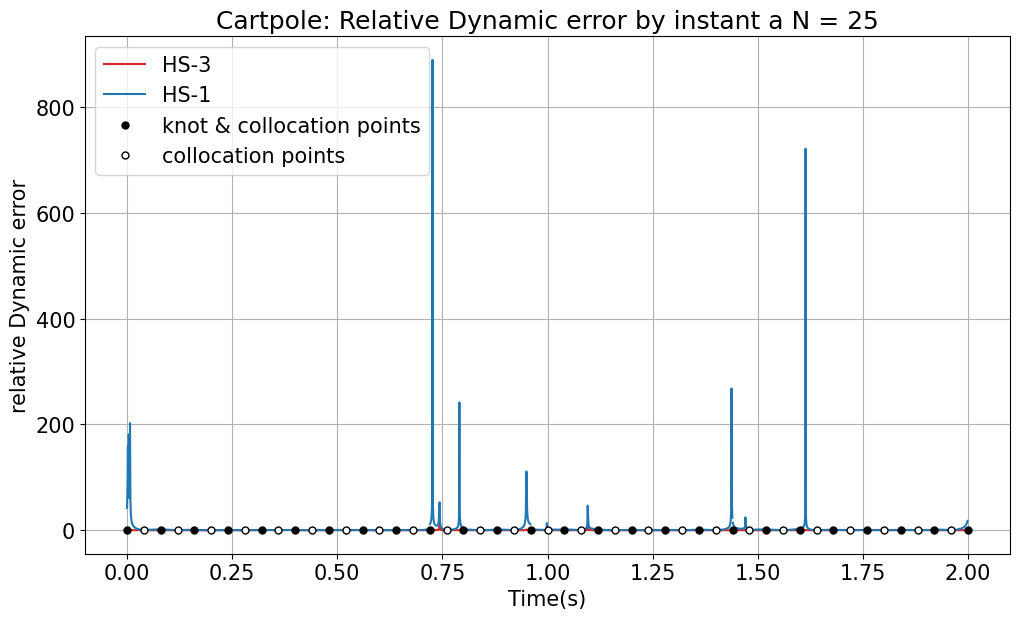

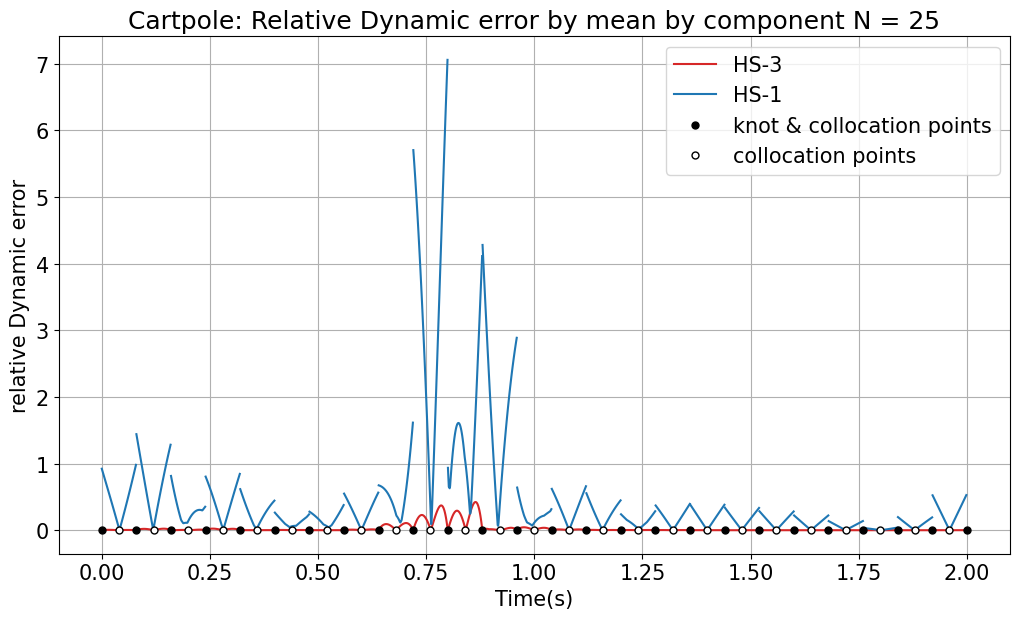

In [76]:
schemes = ['hsn_parab','hs_parab']
N = 25
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

In [77]:
for scheme in results.keys():
    _n = 25 if 'hs' in scheme else 50
    _e = results[scheme][_n]['rel_dyn_err_3_arr_by_mean_by_component_sum']
    print(f'scheme {scheme.ljust(12)} N {_n} avg {round(np.mean(_e), 4)} max {round(np.max(_e), 3)}')

scheme hs_parab     N 25 avg 0.4888 max 7.055
scheme hsn_parab    N 25 avg 0.0235 max 0.423
scheme trapz        N 50 avg 3.014 max 12.723
scheme trapz_n      N 50 avg 0.0486 max 0.985


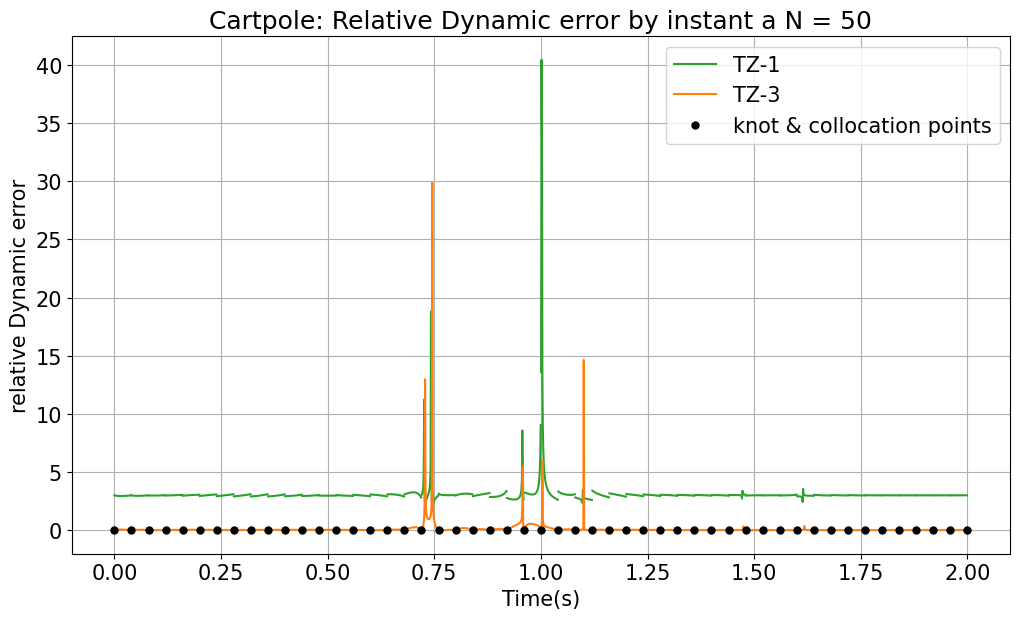

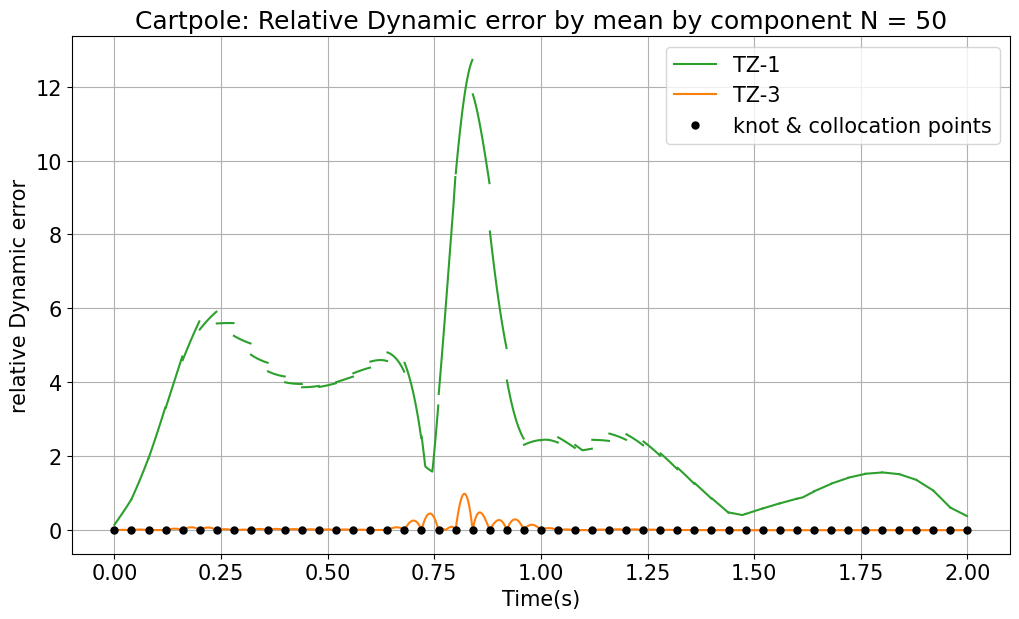

In [78]:
schemes = ['trapz', 'trapz_n']
N = 50
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


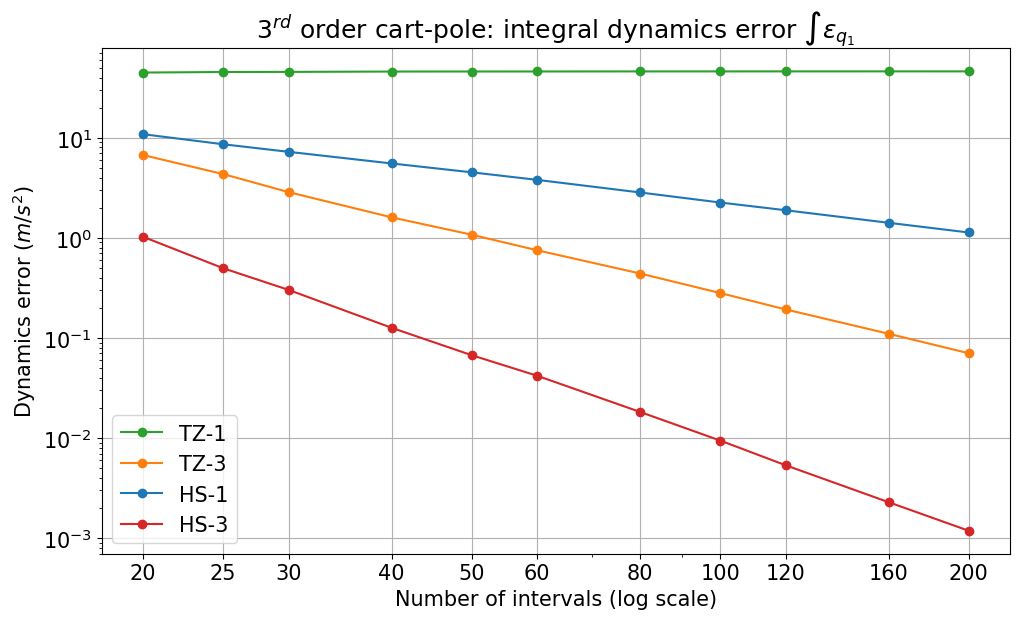

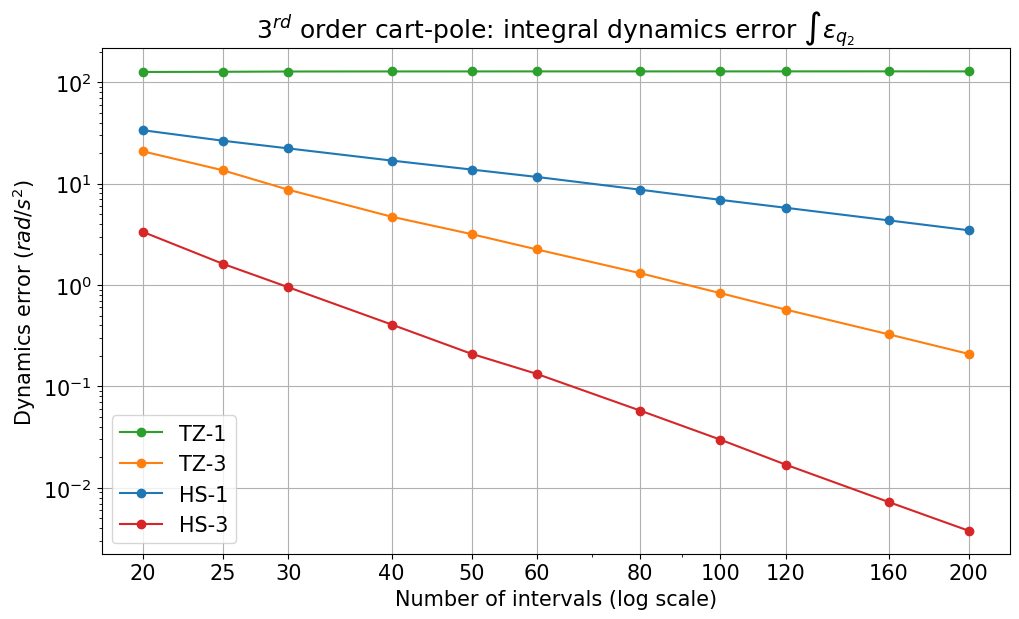

In [93]:
data_array = ['err_q_acum','err_v_acum','err_3_acum','cpudt']
schemes = ['trapz', 'trapz_n','hs_parab', 'hsn_parab',]

data_key = data_array[2]

for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'$3^{rd}$ order cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in schemes:
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **scheme_kwargs(key, longlabel=False))
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **scheme_kwargs(key, longlabel=False))
    plt.yscale('log')
    plt.xscale('log')
    ticks = np.array(results[key]['N_arr'])
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of intervals (log scale)')
    plt.grid()
    plt.legend()
    units = 'm/s^2' if qq == 0 else'rad/s^2'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    plt.savefig(f'2d_order/Cartpole_deriv_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


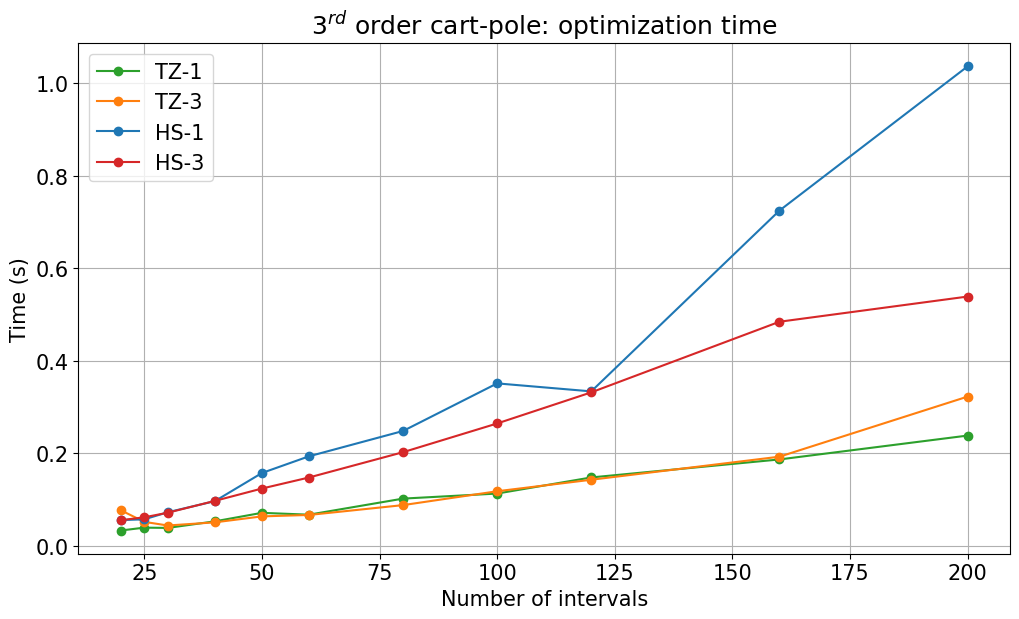

In [94]:
schemes = ['hsn_parab','hs_parab', 'trapz', 'trapz_n']
titles = ['Nth order Hermite Simpson', 'Hermite Simpson','Trapezoidal', 'Nth order Trapezoidal']
plt.figure(figsize=[10,6])
for ii in [2,3,1,0]:
    key = schemes[ii]
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.title('$3^{rd}$ order cart-pole: optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
plt.savefig(f'2d_order/Cartpole_deriv_optimization_time_vs_interval_number.eps', format='eps')

In [84]:
# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_n', 'hs_parab', 'hsn_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 3:', results[key][N]['err_3'])

scheme: trapz N: 50 
	time: 0.07093417644500732 
	Err 1: [0.00600287 0.01692456 0.00553843] 
	Err 3: [ 45.92567234 127.61383436  41.54265449]
scheme: trapz_n N: 50 
	time: 0.06322929859161378 
	Err 1: [1.41016791e-21 5.26101104e-21 0.00000000e+00] 
	Err 3: [1.07516699e+00 3.17356971e+00 5.19726277e-15]
scheme: hs_parab N: 25 
	time: 0.0568789005279541 
	Err 1: [0.00106544 0.00330027 0.00051309] 
	Err 3: [ 8.61437612 26.45103836  3.89398816]
scheme: hsn_parab N: 25 
	time: 0.06124417781829834 
	Err 1: [2.40483886e-10 2.05999086e-09 0.00000000e+00] 
	Err 3: [4.97150097e-01 1.61584160e+00 7.03740606e-16]


## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)